In [ ]:
"""
Channel Interpolation for DAS (Distributed Acoustic Sensing) Data
================================================================

This notebook performs interpolation of DAS cable positions along a wellbore trajectory
and implements seismic event backprojection for visualization of P and S wave arrivals.

Key functionality:
- Load and process well survey data
- Interpolate DAS sensor positions using both MD-based and arc-length based methods
- Visualize cable trajectories in 3D
- Backproject seismic events to DAS channels
"""

# Core data manipulation and analysis libraries
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go

import numpy as np
from scipy.interpolate import interp1d

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# === DAS Channel Configuration Parameters ===
# These parameters define the physical characteristics of the DAS installation

num_channels = 1496  # Total number of DAS channels along the cable
channel_distance = 1.021095  # Physical spacing between adjacent channels in meters
channel_distance_ft = channel_distance * 3.280839895  # Convert to feet for compatibility with survey data

# 1. Visualization of the FORGE DAS cable according to the Survey Report

In [3]:
# === Load Well Survey Data ===
# Load directional survey data from Excel file containing wellbore trajectory points
file_path = '16B(78)-32 Well Survey/16B(78)-32 Final Survey Report.xlsx'

# Read Excel file starting from row 21 (header=20, 0-indexed)
# This skips the metadata/header information to get to the actual survey data
survey_df = pd.read_excel(file_path, header=20)

# Remove the first 3 rows which contain units/formatting info, not actual data points
survey_df = survey_df.drop(labels=[0, 1, 2], axis=0)

# Reset index to start from 0 after dropping rows
survey_df.reset_index(drop=True, inplace=True)

In [4]:
survey_df

MD        INC     AZI      TVD    SSTVD      N/S     NORTHING  \
0          0          0       0        0  5447.65        0  13987765.96   
1         25       0.22   52.11       25  5422.65     0.03  13987765.99   
2         50       0.45   52.11       50  5397.65     0.12  13987766.08   
3         75       0.36   38.82       75  5372.65     0.24   13987766.2   
4        100       0.14   58.33      100  5347.65     0.32  13987766.28   
..       ...        ...     ...      ...      ...      ...          ...   
423  10638.9  5   63.61  104.66  8259.97 -2812.32 -1076.17  13986689.79   
424    10703  0   64.72  103.54  8287.88 -2840.23 -1090.21  13986675.75   
425    10798  0   65.03  103.34  8328.21 -2880.56  -1110.2  13986655.76   
426    10862  0   64.90  102.17   8355.3 -2907.65    -1123  13986642.96   
427    10947  0   64.90  102.17  8391.36 -2943.71 -1139.23  13986626.73   

         E/W     EASTING     VSEC   DLS  
0          0  1097907.09        0     0  
1       0.04  1097907.12     0.03  0.88  
2       0.15  1097907.24     0.11  0.92  
3       0.28  1097907.37      0.2  0.52  
4       0.36  1097907.44     0.25  0.93  
..       ...         ...      ...   ...  
423  3932.41  1101839.49  4075.52  2.34  
424  3988.32   1101895.4   4133.1  2.34  
425  4071.97  1101979.06  4218.96  0.38  
426  4128.53  1102035.61   4276.8  1.67  
427  4203.77  1102110.86  4353.52     0  

[428 rows x 11 columns]

In [ ]:
# === 3D Visualization of DAS Cable Trajectory ===


# Create 3D scatter plot of the cable path using survey coordinates
# Skip first row [1:] as it may contain header/units information
fig = go.Figure(data=[go.Scatter3d(
    x=survey_df["EASTING"][1:],      # X-coordinate: Easting (UTM or local grid)
    y=survey_df["NORTHING"][1:],     # Y-coordinate: Northing (UTM or local grid)  
    z=survey_df["TVD"][1:],          # Z-coordinate: True Vertical Depth
    mode='lines+markers',
    # Color points by measured depth (MD) to show progression along wellbore
    marker=dict(size=3, color=survey_df["MD"][1:], colorscale='Viridis'),
    line=dict(width=2, color=survey_df["MD"][1:], colorscale='Viridis')
)])

# Configure 3D scene layout for geoscience visualization
fig.update_layout(
    scene=dict(
        xaxis_title='Easting [ft]',
        yaxis_title='Northing [ft]',
        zaxis_title='TVD [ft]',
        # Reverse Z-axis so depth increases downward (standard in geoscience)
        zaxis=dict(autorange='reversed')
    ),
    title='3D Visualization of DAS Cable Path',
    margin=dict(l=0, r=0, b=0, t=40),
    # Maintain aspect ratio based on actual data dimensions
    scene_aspectmode='data'
)

fig.show()

# 2. Interpolate DAS Channel Locations with Correct Specifications

This notebook section generates a CSV file containing uniformly spaced Distributed Acoustic Sensing (DAS) channel positions for the FORGE 16 (78)-32 well. It meets the specific requirements:
- Starting MD: 5,369.35 feet (converted to meters)
- Exactly 1496 channel locations
- Step size: 1.02109 meters between consecutive channels
- Interpolated EASTING_m and NORTHING_m coordinates for each MD location


The process:
1. Load the well trajectory survey data and clean numeric fields.
2. Convert all spatial measurements from feet (survey standard) to meters.
3. Define DAS sensor parameters:
   - Starting Measured Depth (MD): 5,369.35 feet → converted to meters
   - Total number of channels: 1,496
   - Sensor spacing: 1.02109 meters between consecutive channels
4. Create an array of MD values corresponding to each sensor location.
5. Use cubic spline interpolation (based on the well survey) to compute:
   - EASTING_m: Easting coordinate in meters
   - NORTHING_m: Northing coordinate in meters
   - TVD_m: True Vertical Depth in meters
6. Save the interpolated coordinates for all 1,496 DAS channels to a CSV file.
7. Produce a 3D comparison plot showing:
   - Original survey trajectory
   - Interpolated DAS positions
   - Anchor reference points along the cable

Purpose:
The output CSV can be used for further arrival time analysis.

In [ ]:
# === DAS Channel Position Interpolation Using Measured Depth ===
# === 0. Parameters ===
feet_to_meters = 0.3048  # Conversion factor from feet to meters
sensor_spacing = 1.021095  # meters between consecutive DAS sensors
sensor_start_md = 5369.3 * feet_to_meters # feet converted to meters, first sensor measured depth
number_of_sensors = 1496  # Total number of DAS sensors along the cable

anchors_path = 'anchors/16Bdas_information_GES_20240330_v1_formated.csv'
forge_sensor_locations = 'interpolated_das_positions_cubic_1496.csv'


# === 1. Load and Process Trajectory Data ===
survey_df = pd.read_excel(file_path, header=20)
survey_df = survey_df.drop(labels=[0, 1, 2], axis=0)
survey_df.reset_index(drop=True, inplace=True)

# Clean data: convert string representations to numeric values
# Handle commas in numbers and strip whitespace
for col in survey_df.columns:
    survey_df[col] = pd.to_numeric(survey_df[col].astype(str).str.strip().str.replace(",", ""), errors="coerce")

# === 1.5. Load Anchor Reference Points ===
# Anchors are physical reference points used for DAS cable positioning
anchors_df = pd.read_csv(anchors_path)
anchors_df["depth_m"] = anchors_df["depth"] * feet_to_meters  # Convert feet to meters

# === 2. Unit Conversion: Feet to Meters ===
# Convert all spatial coordinates from feet (survey standard) to meters (SI units)
survey_df["MD_m"] = survey_df["MD"] * feet_to_meters        # Measured Depth
survey_df["TVD_m"] = survey_df["TVD"] * feet_to_meters      # True Vertical Depth
survey_df["EASTING_m"] = survey_df["EASTING"] * feet_to_meters    # Easting coordinate
survey_df["NORTHING_m"] = survey_df["NORTHING"] * feet_to_meters  # Northing coordinate

# === 3. Generate Uniformly Spaced Measured Depth Points ===
# Create MD points at regular intervals matching DAS sensor spacing
md_interp = sensor_start_md + sensor_spacing * np.arange(number_of_sensors)

# === 4. Cubic Spline Interpolation ===
# Interpolate 3D coordinates at uniform MD intervals using cubic splines
# Cubic splines provide smooth interpolation while preserving trajectory shape
interp_east = interp1d(survey_df["MD_m"], survey_df["EASTING_m"], kind='cubic')
interp_north = interp1d(survey_df["MD_m"], survey_df["NORTHING_m"], kind='cubic')
interp_tvd = interp1d(survey_df["MD_m"], survey_df["TVD_m"], kind='cubic')

# Evaluate interpolation functions at target MD points
easting_new = interp_east(md_interp)
northing_new = interp_north(md_interp)
tvd_new = interp_tvd(md_interp)

# === 5. Create DAS Channel Position DataFrame ===
channel_coords_df = pd.DataFrame({
    "MD_m": md_interp,
    "EASTING_m": easting_new,
    "NORTHING_m": northing_new,
    "TVD_m": tvd_new
})

# === 6. Export Results ===
channel_coords_df.to_csv(forge_sensor_locations, index=False)

# === 7. Comparative 3D Visualization ===
import plotly.graph_objects as go

fig = go.Figure()

# Plot original survey points in red
fig.add_trace(go.Scatter3d(
    x=survey_df["EASTING_m"],
    y=survey_df["NORTHING_m"],
    z=survey_df["TVD_m"],
    mode='markers',
    name='Original Cable',
    line=dict(color='red', width=2),
    marker=dict(size=3, color='red'),
))

# Plot interpolated DAS positions in blue
fig.add_trace(go.Scatter3d(
    x=channel_coords_df["EASTING_m"],
    y=channel_coords_df["NORTHING_m"],
    z=channel_coords_df["TVD_m"],
    mode='markers',
    name='Interpolated Cable',
    line=dict(color='blue', width=2),
    marker=dict(size=2, color='blue'),
))

# Add anchor reference points in green
fig.add_trace(go.Scatter3d(
    x=anchors_df["utm_easting"],
    y=anchors_df["utm_northing"],
    z=anchors_df["depth_m"],
    mode='markers',
    name='Anchors',
    line=dict(color='black', width=4),
    marker=dict(size=4, color='green', symbol='circle'),
))

# Configure visualization layout
fig.update_layout(
    scene=dict(
        xaxis_title='Easting [m]',
        yaxis_title='Northing [m]',
        zaxis_title='TVD [m]',
        zaxis=dict(autorange='reversed')  # Depth increases downward
    ),
    title='Original vs Interpolated Cable vs Anchors',
    scene_aspectmode='data',
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=0.02, y=0.98)
)

fig.show()

channel_coords_df is the variable (dataframe) that contains 1496 channel locations

In [ ]:
# === 2D Trajectory Analysis Function ===

def plot_tvd_vs_coordinates(df_original, df_interpolated, anchors_df=None, title_suffix=""):
    """
    Create 2D projections of wellbore trajectory showing TVD vs horizontal coordinates.
    
    This function generates a 2x1 subplot layout displaying True Vertical Depth (TVD) 
    as a function of Easting and Northing coordinates separately. This visualization 
    helps analyze the vertical profile of the wellbore in different horizontal directions.
    
    Parameters
    ----------
    df_original : pd.DataFrame
        Original trajectory data with columns: EASTING_m, NORTHING_m, TVD_m
        Contains survey points from directional drilling measurements
    df_interpolated : pd.DataFrame  
        Interpolated trajectory data with columns: EASTING_m, NORTHING_m, TVD_m
        Contains positions interpolated at regular DAS channel spacing
    anchors_df : pd.DataFrame, optional
        Anchor reference points with columns: utm_easting, utm_northing, depth_m
        Physical markers used for DAS cable positioning validation
    title_suffix : str, optional
        Additional text to append to the plot title (e.g., interpolation method)
    
    Returns
    -------
    plotly.graph_objects.Figure
        Interactive plotly figure with 2D trajectory projections
    """
    
    # Create subplot structure: 2 rows, 1 column for TVD vs Easting/Northing
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('TVD vs Easting', 'TVD vs Northing'),
        vertical_spacing=0.12,  # Space between subplots
        x_title='Coordinate [m]',
        y_title='TVD [m]'
    )
    
    # === Top Subplot: TVD vs EASTING ===
    
    # Original survey points with connecting lines
    fig.add_trace(
        go.Scatter(
            x=df_original["EASTING_m"],
            y=df_original["TVD_m"],
            mode='markers+lines',
            name='Original Cable',
            line=dict(color='red', width=2),
            marker=dict(size=4, color='red'),
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Interpolated DAS channel positions (markers only for clarity)
    fig.add_trace(
        go.Scatter(
            x=df_interpolated["EASTING_m"],
            y=df_interpolated["TVD_m"],
            mode='markers',
            name='Interpolated Cable',
            marker=dict(size=2, color='blue'),
            showlegend=True
        ),
        row=1, col=1
    )
    
    # Add anchor points if provided
    if anchors_df is not None:
        fig.add_trace(
            go.Scatter(
                x=anchors_df["utm_easting"],
                y=anchors_df["depth_m"],
                mode='markers',
                name='Anchors',
                marker=dict(size=6, color='green', symbol='diamond'),
                showlegend=True
            ),
            row=1, col=1
        )
    
    # === Bottom Subplot: TVD vs NORTHING ===
    
    # Original survey points (don't show in legend again)
    fig.add_trace(
        go.Scatter(
            x=df_original["NORTHING_m"],
            y=df_original["TVD_m"],
            mode='markers+lines',
            name='Original Cable',
            line=dict(color='red', width=2),
            marker=dict(size=4, color='red'),
            showlegend=False  # Avoid duplicate legend entries
        ),
        row=2, col=1
    )
    
    # Interpolated DAS positions
    fig.add_trace(
        go.Scatter(
            x=df_interpolated["NORTHING_m"],
            y=df_interpolated["TVD_m"],
            mode='markers',
            name='Interpolated Cable',
            marker=dict(size=2, color='blue'),
            showlegend=False
        ),
        row=2, col=1
    )
    
    # Anchor points in Northing projection
    if anchors_df is not None:
        fig.add_trace(
            go.Scatter(
                x=anchors_df["utm_northing"],
                y=anchors_df["depth_m"],
                mode='markers',
                name='Anchors',
                marker=dict(size=6, color='green', symbol='diamond'),
                showlegend=False
            ),
            row=2, col=1
        )
    
    # === Layout Configuration ===
    fig.update_layout(
        title=f'TVD vs Coordinates {title_suffix}',
        height=800,  # Taller figure for better visibility of both subplots
        margin=dict(l=60, r=60, b=60, t=80),
        legend=dict(x=0.02, y=0.98)  # Position legend in top-left
    )
    
    # Customize axis labels for each subplot
    fig.update_xaxes(title_text="Easting [m]", row=1, col=1)
    fig.update_xaxes(title_text="Northing [m]", row=2, col=1)
    
    # Reverse Y-axes so depth increases downward (geoscience convention)
    fig.update_yaxes(title_text="TVD [m]", autorange='reversed', row=1, col=1)
    fig.update_yaxes(title_text="TVD [m]", autorange='reversed', row=2, col=1)
    
    return fig

# === Generate 2D Trajectory Plot ===
# Create visualization comparing original survey and interpolated DAS positions
fig = plot_tvd_vs_coordinates(survey_df, channel_coords_df, anchors_df, "- Cubic Interpolation")
fig.show()

In [15]:
# === Utility Functions for Seismic Event Processing ===
import math

def compute_distance(point1, point2):
    """
    Calculate 3D Euclidean distance between two spatial points.
    
    This function is used to compute travel distances from seismic event locations
    to individual DAS channel positions for seismic wave arrival time calculations.
    
    Parameters
    ----------
    point1 : tuple
        First point coordinates as (easting1, northing1, depth1)
    point2 : tuple  
        Second point coordinates as (easting2, northing2, depth2)
        
    Returns
    -------
    float
        Euclidean distance between the two points in the same units as input coordinates
        
    Notes
    -----
    All coordinates should be in the same unit system (e.g., all in meters).
    For seismic applications, this distance is used with P and S wave velocities
    to calculate differential arrival times across the DAS array.
    """
    e1, n1, d1 = point1  # Unpack first point coordinates
    e2, n2, d2 = point2  # Unpack second point coordinates
    
    # Calculate 3D Euclidean distance using Pythagorean theorem
    distance = math.sqrt((e1 - e2)**2 + (n1 - n2)**2 + (d1 - d2)**2)
    return distance

In [16]:
channel_coords_df

MD_m      EASTING_m    NORTHING_m        TVD_m
0     1636.562640  334655.430528  4.263463e+06  1636.264542
1     1637.583735  334655.426041  4.263463e+06  1637.285238
2     1638.604830  334655.420265  4.263463e+06  1638.306060
3     1639.625925  334655.413175  4.263463e+06  1639.327026
4     1640.647020  334655.404807  4.263463e+06  1640.348103
...           ...            ...           ...          ...
1491  3159.015285  335767.490503  4.263160e+06  2480.606160
1492  3160.036380  335768.397730  4.263160e+06  2481.046346
1493  3161.057475  335769.305532  4.263159e+06  2481.485871
1494  3162.078570  335770.213934  4.263159e+06  2481.924811
1495  3163.099665  335771.122945  4.263159e+06  2482.363243

[1496 rows x 4 columns]

In [ ]:
# === Load Seismic Event Catalog ===
"""
Load and prepare seismic event catalogs from Wells 16A and 16B for analysis.

Steps:
1. Define file paths for seismic catalogs and raw DAS data.
2. Load all FORGE-related CSV catalog files from both wells.
3. Concatenate individual catalog DataFrames into one master catalog dataframe.
4. Clean column names for consistency.
5. Filter out events with invalid depths or missing DAS data files.
6. Sort events by moment magnitude, prioritizing larger events for clearer seismic signals.

"""

import os 
import dascore as dc

# === Configuration Parameters ===
# File paths for seismic event catalogs from different wells
catalogA_path = '../GES16Aand16BStimulationMonitoringApril2024/16AStimulationCatalogues'
catalogB_path = '../GES16Aand16BStimulationMonitoringApril2024/16BStimulationCatalogues'

# Path to raw DAS data repository
forge_path = '/bedrettolab/E1B/DAS/2024_FORGE/DATA_RAW_fromOpenei/April_2024/v2.0.0'

# Visualization settings
show_images = False
num_images = 5
width_mm = 85
dpi = 300
width_in = width_mm / 25.4
height_in = width_in * 0.75

# === Load and Concatenate Seismic Catalogs ===
# Process all CSV files containing seismic event information
dataframes = []

# Load catalogs from Well 16A
for file_name in os.listdir(catalogA_path):
    file_path = os.path.join(catalogA_path, file_name)
    # Process only FORGE catalog files (CSV format)
    if file_name.endswith('.csv') and file_name.startswith('FORGE'):
        survey_df = pd.read_csv(file_path)
        if not survey_df.empty:  # Only add non-empty catalogs
            dataframes.append(survey_df)

# Load catalogs from Well 16B  
for file_name in os.listdir(catalogB_path):
    file_path = os.path.join(catalogB_path, file_name)
    if file_name.endswith('.csv') and file_name.startswith('FORGE'):
        survey_df = pd.read_csv(file_path)
        if not survey_df.empty:
            dataframes.append(survey_df)

# === Catalog Data Processing ===
# Combine all individual catalog files into a single DataFrame
catalog_df = pd.concat(dataframes, ignore_index=True)

# Clean column names: remove spaces and replace with underscores
catalog_df.columns = catalog_df.columns.str.strip().str.replace(' ', '_')

# === Data Quality Filtering ===
# Remove events with invalid depth values (surface or above-ground events)
catalog_df = catalog_df[catalog_df['Depth'] > 0]

# Keep only events that have associated DAS data files
catalog_df = catalog_df[catalog_df['Matched_File'].notna()]

# Sort events by moment magnitude (largest events first)
# Large events provide clearer signals for analysis
catalog_df.sort_values(by='MomMag', ascending=False, inplace=True)

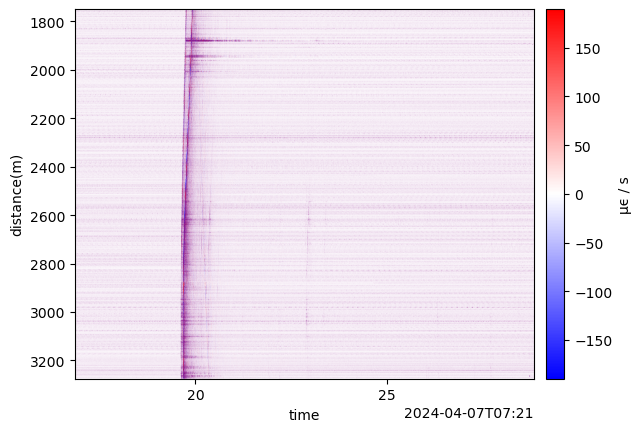

In [18]:
# === Load and Visualize Largest Seismic Event ===
# Select the highest moment magnitude event for detailed analysis
event = catalog_df.head(1)

# Construct file path for the DAS data corresponding to this event
file_path = os.path.join(forge_path, event['Matched_File'].item())

# Use local test file for development/testing
# This is the largest event in the catalog, saved locally for faster access
file_path = "../downsample_test/16B_StrainRate_20240407T072116+0000_34572.h5"

try:
    # Load DAS data using dascore library
    # [0] selects first (and likely only) patch from the file
    # transpose() swaps time/distance axes for standard visualization format
    patch = dc.spool(file_path)[0].transpose()
    
    # Create waterfall plot showing strain rate vs time and distance
    # scale=0.05 adjusts amplitude scaling for better visualization
    patch.viz.waterfall(show=True, scale=0.05)
    
except Exception as e:
    print(f"Error loading DAS data from {file_path}: {e}")

In [ ]:
# Analyze the details of the selected patch.
patch

DASCore Patch ⚡
---------------
➤ Coordinates (distance: 1496, time: 60000)
    *distance: CoordRange( min: 1.75e+03 max: 3.28e+03 step: 1.0210915 shape: (1496,) dtype: float32 units: m )
    *time: CoordRange( min: 2024-04-07T07:21:16.8446839 max: 2024-04-07T07:21:28.844423901 step: 0.000199999s shape: (60000,) dtype: datetime64[ns] units: s )
➤ Data (float32, units: 1.0 µϵ / s)
   [[ -3.841  -2.171   8.367 ...  -8.236  11.333 -16.362]
    [  2.253  -8.781  -1.619 ...  -6.363   4.513  -9.807]
    [  3.203  -6.447  -4.899 ...   0.94   -7.157   3.418]
    ...
    [  2.118  -4.314  -2.778 ...   7.013   1.819  -2.478]
    [  6.34    0.037   0.589 ... -15.259   3.204  -6.326]
    [ 24.357 -11.694  13.845 ...  -8.914   5.073 -10.84 ]]
➤ Attributes
    data_units: µϵ / s
    instrument_id: S236106002001
    gauge_length: 1.0210915
    index_of_refraction: 1.468
    phase_to_strain: -0.10775734
    instrument_model: NBX-S4110
    distance_decimation_filter: 1
    time_decimation_filter: 1

In [ ]:
# Analyze the corresponding seismic event from the catalog.
event

Source    Trig_Date         Trig_Time  Origin_Date       Origin_Time  \
2578  7847.0     7/4/2024   01:21:19.734250     7/4/2024   01:21:19.527279   

            Profile  Status  Cluster       Y       X  ...  MomMag     PGV  \
2578        Primary     2.0      0.0 -2170.0  2150.0  ...    1.42  187.75   

      Stage P_S/N  S_S/N  Quality      Error      Location rms_Noise  \
2578     10  31.5   56.2      4.2  1000000.0       L2 msmx      57.0   

                                      Matched_File  
2578  16B_StrainRate_20240407T072116+0000_34572.h5  

[1 rows x 21 columns]

In [21]:
# === Parse Seismic Event Trigger Time ===
from datetime import datetime, timedelta

# Extract trigger date and time from catalog entry
# These represent the P-wave arrival time at the monitoring station
date_str = event['Trig_Date'].item().strip()  # Remove any whitespace
time_str = event['Trig_Time'].item().strip()

# Combine date and time strings for parsing
datetime_str = f"{date_str} {time_str}"

# Parse the combined string into a datetime object
# Format: DD/MM/YYYY HH:MM:SS.ffffff (day/month/year with microseconds)
dt = datetime.strptime(datetime_str, '%d/%m/%Y %H:%M:%S.%f')

# Display parsed results for verification
print(datetime_str)
print(dt)

# Example: Calculate time 2 seconds after trigger for reference
print(dt + timedelta(seconds=2))

7/4/2024 01:21:19.734250
2024-04-07 01:21:19.734250
2024-04-07 01:21:21.734250


In [ ]:
# ########## Backprojection ##########
# Method: For each event, take OriginTime from catalog. This indicates the time of the event's occurence,
# at the location specified by X and Y columns in the catalog, which are relative to the wellhead.
# The Depth column indicates the True Vertical depth of the event, which is also relative to the wellhead.
#
# Since the locations (northing, easting and depth) of each DAS channel has been computed earlier, we can
# compute the distance from the event location to each DAS channel location.
#
# The velocities of P and S waves are known, so we can compute the theoretical times of arrival
# of the P and S waves at each channel by adding the travel time from the origin location to the channel location, to the
# event origin time. The pseudo-code for this part is:
#               t_channel = t_origin + distance(origin, channel) / velocity.
# This will give us the time of arrival of the P and S waves at each channel.
# This technique projects seismic event arrival times onto the DAS array based on wave propagation and a uniform velocity model.

# === Wave Velocity Parameters ===
# P and S wave velocities for the FORGE geothermal site (converted to m/s)
vp = 5.821 * 1000  # P-wave velocity: 5.821 km/s -> 5821 m/s
vs = 3.414 * 1000  # S-wave velocity: 3.414 km/s -> 3414 m/s

def backprojection(catalog_event, cable_channel_locs, vp, vs):
    """
    Calculate P and S wave arrival times at each DAS channel for a seismic event.
    
    This function implements seismic wave backprojection by computing travel times
    from a monitoring station (where trigger time is known) to each DAS channel
    position along the wellbore cable. The method assumes:
    1. The trigger time represents P-wave arrival at the station head
    2. Uniform wave velocities throughout the medium
    3. Straight-line ray paths from station head to each channel
    
    Parameters
    ----------
    catalog_event : pd.DataFrame
        Single-row DataFrame containing event information with columns:
        - 'Trig_Time': P-wave arrival time at monitoring station
        - 'Trig_Date': Date of the seismic event
    cable_channel_locs : dict
        Dictionary containing DAS channel positions with keys:
        - 'EASTING_m': Array of easting coordinates in meters
        - 'NORTHING_m': Array of northing coordinates in meters  
        - 'TVD_m': Array of true vertical depth in meters
    head_loc : tuple
        Coordinates of monitoring station head as (easting, northing, depth)
    vp : float
        P-wave velocity in m/s
    vs : float
        S-wave velocity in m/s
        
    Returns
    -------
    tuple
        (p_times, s_times) where:
        - p_times: List of datetime objects for P-wave arrivals at each channel
        - s_times: List of datetime objects for S-wave arrivals at each channel
        
    Notes
    -----
    The backprojection assumes that seismic waves travel from the monitoring
    station head to each DAS channel. Arrival times are calculated by:
    t_channel = t_trigger - (distance / velocity)
    
    The subtraction accounts for the fact that waves reach closer channels
    before reaching the monitoring station head.
    """
    # Extract origin timing information from catalog
    trig_time = catalog_event['Origin_Time'].item().strip()
    trig_date = catalog_event['Origin_Date'].item().strip()

    # Extract event location coordinates in meters, relative to origin (assume wellhead)
    trig_easting = catalog_event['X'].item() * feet_to_meters
    trig_northing = catalog_event['Y'].item() * feet_to_meters
    trig_tvd = catalog_event['Depth'].item() * feet_to_meters

    trig_easting_abs = 1097907.09 * feet_to_meters + trig_easting # Absolute easting in meters
    trig_northing_abs = 13987765.96 * feet_to_meters + trig_northing # Absolute northing in meters

    # Parse the trigger datetime (reusing variables from previous cell)
    datetime_str = f"{trig_date} {trig_time}"
    trig_dt = datetime.strptime(datetime_str, '%d/%m/%Y %H:%M:%S.%f')

    # Initialize lists for calculated arrival times
    p_times = []
    s_times = []

    # Calculate arrival times for each DAS channel
    for i in range(len(cable_channel_locs['EASTING_m'])):
        # Current channel position
        channel_loc = (
            cable_channel_locs['EASTING_m'][i], 
            cable_channel_locs['NORTHING_m'][i], 
            cable_channel_locs['TVD_m'][i]
        )

        # Update: Compute distance from Event Coordinates to Channel Coordinates
        origin_loc = (trig_easting_abs, trig_northing_abs, trig_tvd)

        # Compute 3D distance from station head to this channel
        distance = compute_distance(origin_loc, channel_loc)

        # Calculate wave arrival times using travel time = distance / velocity
        # Subtract from trigger time since waves reach channels before the head
        p_time = trig_dt + timedelta(seconds=distance / vp)
        s_time = trig_dt + timedelta(seconds=distance / vs)

        p_times.append(p_time)
        s_times.append(s_time)

    return p_times, s_times

In [ ]:
# === Execute Backprojection for Selected Event ===
# Calculate P and S wave arrival times for all DAS channels

# Perform backprojection calculation for the selected seismic event
p_picks, s_picks = backprojection(
    event,           # Seismic event from catalog
    channel_coords_df,          # DAS channel positions
    vp,              # P-wave velocity
    vs               # S-wave velocity
)

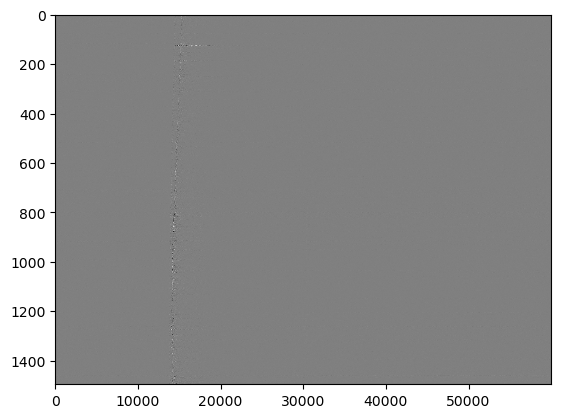

In [ ]:
# === Basic DAS Data Visualization ===

# Display the DAS strain rate data as a grayscale image
# - X-axis: Time samples
# - Y-axis: Channel number (distance along cable)
# - Intensity: Strain rate amplitude (normalized by 0.05 scaling factor)
vm0 = np.percentile(patch.data, 99)
std0 = np.std(patch.data)

plt.imshow(patch.data, cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')

In [29]:
# === Convert Pick Times to DAS Sample Numbers ===
# Transform datetime-based wave arrival times into DAS data array indices

# Initialize lists for sample number storage
p_sample_num = []  # P-wave arrival sample numbers
s_sample_num = []  # S-wave arrival sample numbers

# Extract DAS timing parameters for conversion
patch_min_time = patch.coords.time.min() - np.timedelta64(6, 'h')  # UTC-corrected start time
patch_step = patch.coords.time.step  # Sample period

def get_sample_number(pick_time, patch_min_time, sample_period):
    """
    Convert a seismic wave arrival time to the corresponding DAS sample index.
    
    This function maps datetime-based wave arrival times from backprojection
    to integer sample indices in the DAS data array, enabling overlay of
    theoretical arrivals on the actual recorded data.
    
    Parameters
    ----------
    pick_time : datetime
        Wave arrival time from backprojection calculation
    patch_min_time : numpy.datetime64
        Start time of the DAS data recording
    sample_period : numpy.timedelta64
        Time interval between consecutive DAS samples
        
    Returns
    -------
    int
        Sample index corresponding to the wave arrival time
        
    Notes
    -----
    The conversion assumes uniform sampling throughout the DAS recording.
    Sample index = (arrival_time - start_time) / sample_period
    """
    # Convert pick time to numpy datetime64 for consistent arithmetic
    pick_time = np.datetime64(pick_time, 'ns')
    
    # Calculate sample index using time difference and sampling rate
    return int((pick_time - patch_min_time) / sample_period)

# === Process All Channel Pick Times ===
# Convert P and S wave arrival times to sample indices for each DAS channel
for channel_id, (p_pick, s_pick) in enumerate(zip(p_picks, s_picks)):
    
    # Calculate sample numbers for both wave types at this channel
    p_sample_idx = get_sample_number(p_pick, patch_min_time, patch_step)
    s_sample_idx = get_sample_number(s_pick, patch_min_time, patch_step)
    
    # Store as (channel_id, sample_number) tuples
    p_sample_num.append((channel_id, p_sample_idx))
    s_sample_num.append((channel_id, s_sample_idx))


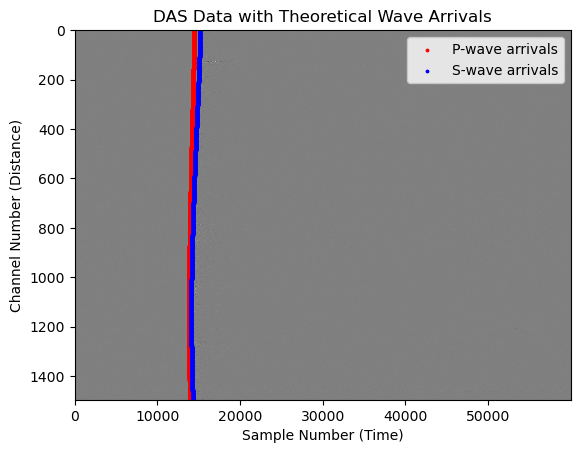

In [ ]:
# === Overlay Seismic Wave Arrivals on DAS Data ===
# Create final visualization showing theoretical P and S wave arrivals
# overlaid on the actual recorded DAS strain rate data

# Display the DAS data as background grayscale image
vm0 = np.percentile(patch.data, 99)
std0 = np.std(patch.data)

plt.imshow(patch.data, cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')

# === Prepare P-wave Picks for Plotting ===
# Subsample picks for clearer visualization (every 7th channel)
p_sample_num_plot = p_sample_num

# Extract coordinates for scatter plot
# X-coordinates: sample numbers (time axis)
xp = [p_sample[1] for p_sample in p_sample_num_plot]
# Y-coordinates: channel IDs (distance axis)  
yp = [p_sample[0] for p_sample in p_sample_num_plot]

# === Prepare S-wave Picks for Plotting ===
# Subsample S-wave picks (every 7th channel for consistency)
s_sample_num_plot = s_sample_num

# Extract S-wave coordinates
xs = [s_sample[1] for s_sample in s_sample_num_plot]
ys = [s_sample[0] for s_sample in s_sample_num_plot]

# === Overlay Wave Arrival Picks ===
# Plot P-wave arrivals as red points
plt.scatter(xp, yp, c='red', s=1, marker='.', label='P-wave arrivals')

# Plot S-wave arrivals as blue points  
plt.scatter(xs, ys, c='blue', s=1, marker='.', label='S-wave arrivals')

# Add labels and display
plt.xlabel('Sample Number (Time)')
plt.ylabel('Channel Number (Distance)')
plt.title('DAS Data with Theoretical Wave Arrivals')
plt.legend()
plt.show()

# === Interpretation Notes ===
# - Red dots: Theoretical P-wave arrival times from backprojection
# - Blue dots: Theoretical S-wave arrival times from backprojection  
# - Gray background: Actual recorded DAS strain rate data
# - The overlay validates the backprojection method by comparing theoretical
#   arrivals with observable features in the recorded seismic data